In [1]:
%matplotlib ipympl
import os
import os.path as path
import logging, sys
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets
from ipywidgets import HBox, VBox
from IPython.display import clear_output
from IPython.display import display
from ipywidgets import IntSlider, Output
from itertools import product
from scipy.signal import find_peaks
import math
from mpl_toolkits.mplot3d import Axes3D

# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, data_tools, variables, calibration, data_loadcrop
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.calibration_tools import dataset_path_qt
from pyccapt.calibration.leap_tools import ccapt_tools

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

In [4]:
# Disable showing logging in Jupyter notebook
logging.disable(sys.maxsize)

In [5]:
button = widgets.Button(
    description='load dataset',
)

@button.on_click
def open_file_on_click(b):
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [6]:
tdc, pulse_mode, flightPathLength_d, t0_d, max_mc, det_diam = wd.dataset_tdc_selection()
display(tdc, det_diam, pulse_mode, flightPathLength_d, t0_d)

Dropdown(description='Data mode:', options=('surface_concept', 'roentdec', 'leap_epos', 'leap_pos'), value='su…

FloatText(value=78.0, description='Detector diameter:')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=54.0, description='t0:')

$$\textbf{You can specify which dataset to use in below block}$$

In [7]:
dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
dataset_name = os.path.splitext(dataset_name_with_extention)[0]


variables.init()
# variables.path = os.path.join(p, 'tests//data')
variables.result_path = os.path.dirname(dataset_main_path) +  '/tof_calibration/'
if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
print('The result will be saved on the path:', variables.result_path)

filename = dataset_path

head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

if tdc.value == 'leap_pos' or tdc.value == 'leap_epos':
    if tdc.value == 'leap_epos':
        data = ccapt_tools.epos_to_ccapt(filename)
    else:
        print('The file has to be epos. With pos information this tutorial cannot be run')
        data = ccapt_tools.pos_to_ccapt(filename)
else:
    data = data_tools.read_hdf5_through_pandas(filename)


The result will be saved on the path: C:/Users/APTUser/Desktop/OLO_AL_6_data/tof_calibration/


In [8]:
data

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.0,0.0,0.0,0.0,26.784518,5260.239258,5260.239258,52493.0,631.738386,0.0,-0.257878,-2.301796,0,1
1,0.0,0.0,0.0,0.0,27.010308,5260.239258,5260.239258,52549.0,630.305064,0.0,1.187510,1.509061,56,1
2,0.0,0.0,0.0,0.0,26.866870,5260.239258,5260.239258,53132.0,621.499392,0.0,0.741796,-0.038204,583,1
3,0.0,0.0,0.0,0.0,26.774577,5260.239258,5260.239258,53523.0,620.751870,0.0,0.563510,-0.576245,391,1
4,0.0,0.0,0.0,0.0,26.613477,5260.239258,5260.239258,53592.0,628.789446,0.0,-0.012735,-2.209469,69,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776717,0.0,0.0,0.0,0.0,27.017762,5703.551758,5703.551758,4605.0,611.767890,0.0,2.069388,1.149306,196,1
1776718,0.0,0.0,0.0,0.0,27.234073,5703.551758,5703.551758,4668.0,625.607334,0.0,0.767265,3.212327,63,1
1776719,0.0,0.0,0.0,0.0,27.757134,5703.551758,5703.551758,6574.0,607.214178,0.0,-0.089143,0.468000,1906,1
1776720,0.0,0.0,0.0,0.0,27.444189,5703.551758,5703.551758,6834.0,620.477550,0.0,-0.312000,2.731592,260,1


In [9]:
# Remove negative TOF
# threshold = 0
# dld_t_mask = data['t (ns)'].to_numpy()
# dld_t_mask = (dld_t <= threshold)
# data.drop(np.where(dld_t_mask)[0], inplace=True)
# data.reset_index(inplace=True, drop=True)


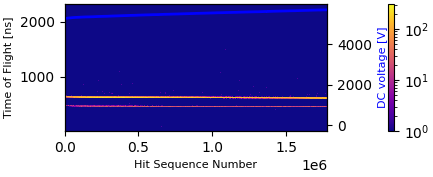

In [10]:
data_loadcrop.plot_crop_experimetn_history(data, save_name=variables.result_path + '//ex_hist_' + dataset_name)


In [11]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data['high_voltage (V)'].to_numpy()
if pulse_mode.value == 'voltage':
    dld_pulseVoltage = data['pulse (V)'].to_numpy()
elif pulse_mode.value == 'laser':
    dld_pulseVoltage = data['pulse (deg)'].to_numpy()
dld_t = data['t (ns)'].to_numpy()
dld_x = data['x_det (cm)'].to_numpy()
dld_y = data['y_det (cm)'].to_numpy()
# copy dld_t to a have a global version of that
variables.dld_t_calib = np.copy(dld_t)
variables.dld_t_calib_backup = np.copy(dld_t)

In [12]:
ion_distance = np.sqrt(flightPathLength_d.value**2 + (dld_x*10)**2 + (dld_y*10)**2)
ion_distance = flightPathLength_d.value / ion_distance
dld_t = dld_t * ion_distance

The peak index for MRP calculation is: 1


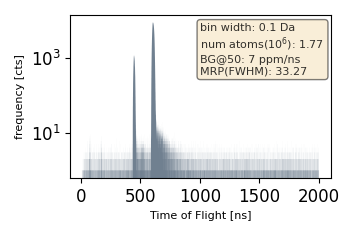

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 33.274135776842925
Peaks  0 is at location and height: (447.46, 1185.00) peak window sides (50.00%) are: (442.18, 454.42)
Peaks  1 is at location and height: (605.99, 8811.00) peak window sides (50.00%) are: (599.22, 617.44)


In [13]:
percent_mrp = 50
peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(dld_t[dld_t < 2000], 0.1, prominence=200, distance=100, h_line=True, text_loc='right', percent=percent_mrp, plot=True, label='tof', fig_name=figname, fig_size=(9/2.54, 6/2.54))
index_max_ini = np.argmax(peaks_y_ini)
mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_ini)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_mrp, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [80]:
# mc = data['mc_c (Da)'].to_numpy()
# peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(mc[mc < 150], 0.1, prominence=50, distance=100, h_line=True, text_loc='right', percent=percent_mrp, plot=True, fig_name=figname)
# index_max_ini = np.argmax(peaks_y_ini)
# mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
# print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
# for i in range(len(peaks_ini)):
#     print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_mrp, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

$$\textbf{Below plotted graph offers peak selection. You can select relevant peaks you want for computation.}$$

The peak index for MRP calculation is: 2


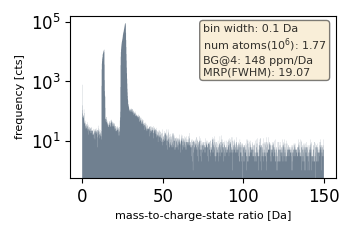

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 19.071428839195153
Peaks  0 is at location and height: (1.10, 113.00) peak window sides (50.00%) are: (1.00, 1.20)
Peaks  1 is at location and height: (13.61, 11766.00) peak window sides (50.00%) are: (12.41, 13.71)
Peaks  2 is at location and height: (26.72, 92529.00) peak window sides (50.00%) are: (25.61, 27.02)


In [14]:
percent_mrp = 50
lim = 150
mc_seb_ini = mc_tools.tof2mc(dld_t, t0_d.value, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength_d.value, mode=pulse_mode.value)
peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(mc_seb_ini[mc_seb_ini < lim], 0.1, prominence=50, distance=100, h_line=True, text_loc='right', percent=percent_mrp, plot=True, fig_name=figname)
index_max_ini = np.argmax(peaks_y_ini)
mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_ini)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_mrp, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [15]:
bin_size=widgets.FloatText(value=0.1, description='bin size:')
prominence=widgets.IntText(value=100, description='peak prominance:')
distance=widgets.IntText(value=500, description='peak distance:')
lim_tof=widgets.IntText(value=1500, description='lim tof/mc:')
percent=widgets.IntText(value=50, description='percent MRP:')

def hist_plot(figname, plot):
    
    with out:
        clear_output(True)
    
        bin_size_p = bin_size.value
        prominence_p = prominence.value
        distance_p = distance.value
        lim_tof_p = lim_tof.value
        percent_p = percent.value
        selector = 'rect'
        peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.dld_t_calib[variables.dld_t_calib < lim_tof_p], bin_size_p, distance=distance_p, percent=percent_p, prominence=prominence_p, selector=selector, plot=plot, label='tof', fig_name=figname+'calib')
        index_max_ini = np.argmax(peaks_y_ini)
        variables.max_peak = peaks_ini[index_max_ini]
        variables.peak = peaks_ini
        mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
        print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
        for i in range(len(peaks_ini)):
            print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_p, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [16]:
sample_size_b = widgets.IntText(value=11, description='sample size:') 
index_fig_b = widgets.IntText(value=1, description='fig index:')
plot_b = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='plot fig:'
)

save_b = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='save fig:'
)
def bowl_correction(dld_x, dld_y, dld_highVoltage, figname=figname):
    with out:
        sample_size_p = sample_size_b.value
        index_fig_p = index_fig_b.value
        plot_p = plot_b.value
        save_p = save_b.value

        calibration.bowl_correction_main(dld_x, dld_y, dld_highVoltage, det_diam.value, sample_size=sample_size_p, calibration_mode='tof',
                                        index_fig=index_fig_p, plot=plot_p, save=save_p)


In [17]:
sample_size_v =widgets.IntText(value=100, description='sample size:') 
index_fig_v = widgets.IntText(value=1, description='fig index:')
plot_v = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='plot fig:'
)
save_v = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='save fig:'
)
mode_v = widgets.Dropdown(
    options=[('ion_seq', 'ion_seq'), ('voltage', 'voltage')],
    description='sample mode:'
)
peak_mode = widgets.Dropdown(
    options=[('peak', 'peak'), ('mean', 'mean'), ('median', 'median')],
    description='peak mode:'
)
def vol_correction(dld_highVoltage, figname):
    with out:
        sample_size_p = sample_size_v.value
        index_fig_p = index_fig_v.value
        plot_p = plot_v.value
        save_p = save_v.value
        mode_p = mode_v.value
        peak_mode_p = peak_mode.value
        calibration.voltage_corr_main(dld_highVoltage, sample_size=sample_size_p, calibration_mode='tof',
                                        index_fig=index_fig_p, plot=plot_p, save=save_p, mode=mode_p, peak_mode=peak_mode_p)


In [19]:
pb_bowl = widgets.HTML(
    value=" ",
    placeholder='Status:',
    description='Status:',
)
pb_vol = widgets.HTML(
    value=" ",
    placeholder='Status:',
    description='Status:',
)
plot_button = widgets.Button(
    description='plot hist',
)
plot_fdm_button = widgets.Button(
    description='plot FDM',
)
reset_button = widgets.Button(
    description='reset back correction',
)
save_button = widgets.Button(
    description='save correction',
)
bowl_button = widgets.Button(
    description='bowl correction',
)
vol_button = widgets.Button(
    description='voltage correction',
)
bin_fdm = widgets.IntText(value=256, description='bin FDM:')
    
@plot_button.on_click
def plot_on_click(b, figname=figname, plot=True):
    hist_plot(figname, plot)

@plot_fdm_button.on_click
def plot_fdm_on_click(b, save=True):
    with out:
        clear_output(True)
        if variables.selected_x1 == 0 or variables.selected_x2 == 0:
            print('Please first select a peak')
        else:
            print('Selected tof are: (%s, %s)' %(variables.selected_x1, variables.selected_x2)) 
            mask_temporal = np.logical_and((variables.dld_t_calib > variables.selected_x1),
                                           (variables.dld_t_calib < variables.selected_x2))
            x = dld_x[mask_temporal]
            y = dld_y[mask_temporal]
            bin_fdm_p = bin_fdm.value
            bins = [bin_fdm_p, bin_fdm_p]

            calibration.plot_FDM(x, y, save, bins)
    
@reset_button.on_click
def reset_on_click(b, figname=figname, plot=True):
    variables.dld_t_calib = np.copy(variables.dld_t_calib_backup)
@save_button.on_click
def save_on_click(b, figname=figname, plot=True):
    variables.dld_t_calib_backup = np.copy(variables.dld_t_calib)
    
@bowl_button.on_click
def bowl_on_click(b, dld_x=dld_x, dld_y=dld_y, dld_highVoltage=dld_highVoltage, figname=figname):
    with out:
        clear_output(True)
        pb_bowl.value = "<b>Starting...</b>"
        if variables.selected_x1 == 0 or variables.selected_x2 == 0:
            print('Please first select a peak')
        else:
            print('Selected tof are: (%s, %s)' %(variables.selected_x1, variables.selected_x2))
            bowl_correction(dld_x, dld_y, dld_highVoltage, figname)  
        pb_bowl.value = "<b>Flished</b>"
@vol_button.on_click
def vol_on_click(b, dld_highVoltage=dld_highVoltage, figname=figname):
    with out:
        clear_output(True)
        pb_vol.value = "<b>Starting...</b>"
        if variables.selected_x1 == 0 or variables.selected_x2 == 0:
            print('Please first select a peak')
        else:
            print('Selected tof are: (%s, %s)' %(variables.selected_x1, variables.selected_x2))
            vol_correction(dld_highVoltage, figname)
        pb_vol.value = "<b>Flished</b>"
    


tab1 = VBox(children=[bin_size, prominence, distance, lim_tof, percent, bin_fdm])
tab2 = VBox(children=[HBox(children=[sample_size_b, index_fig_b, plot_b, save_b]), bowl_button, pb_bowl])
tab3 = VBox(children=[HBox(children=[sample_size_v, index_fig_v, mode_v, peak_mode, plot_v, save_v]), vol_button, pb_vol])

tab = widgets.Tab(children=[tab1, tab2, tab3])
tab.set_title(0, 'tof/mc plot')
tab.set_title(1, 'bowl correction')
tab.set_title(2, 'voltage correction')



display(VBox(children=[tab,HBox(children=[plot_button, plot_fdm_button, save_button, reset_button])]))
out = Output()
display(out)

Output()

In [20]:
# fitresult = [ 1.59856266e+00,  5.68765920e-09, -1.41281563e-04]
# f_v = calibration.voltage_corr(data['high_voltage (V)'].to_numpy(), *fitresult)
# variables.dld_t_calib = variables.dld_t_calib * (1 / f_v)

In [170]:
# parameters = [ 9.88684464e-01, -2.17639093e-04 , 2.36038428e-04,  3.44156992e-05, -2.62895576e-06,  3.28072030e-05]
# f_bowl = calibration.bowl_corr_fit([data['x_det (cm)'].to_numpy()* 10, data['y_det (cm)'].to_numpy()* 10], *parameters)
# variables.dld_t_calib = variables.dld_t_calib * 1 / f_bowl

In [20]:
variables.dld_t_calib_backup = np.copy(variables.dld_t_calib)

In [23]:
def tof_his(bin_size, prominence, distance, percent, selector, plot, figname, lim_dld_t):
    variables.peaks_idx = []
    peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.dld_t_calib[variables.dld_t_calib < lim_dld_t], bin_size, distance=distance, percent=percent, prominence=prominence, selector=selector, plot=plot, label='tof', fig_name=figname)
    index_max_ini = np.argmax(peaks_y_ini)
    variables.max_peak = peaks_ini[index_max_ini]
    variables.peak = peaks_ini
    mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
    print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
    for i in range(len(peaks_ini)):
                   print('Peaks ', i+1, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [24]:
interact_manual(tof_his, bin_size=widgets.FloatText(value=0.1)
               ,prominence=widgets.IntText(value=50), distance=widgets.IntText(value=100), lim_dld_t=widgets.IntText(value=1500)
               ,percent=widgets.IntText(value=50), selector=fixed('peak'), plot=fixed(True), figname=fixed(figname));


interactive(children=(FloatText(value=0.1, description='bin_size'), IntText(value=50, description='prominence'…

In [25]:
isotopeTableFile = '../../../files/isotopeTable.h5'
dataframe = data_tools.read_hdf5_through_pandas(isotopeTableFile)
elementsList = dataframe['element']
elementIsotopeList = dataframe['isotope']
elementMassList =  dataframe['weight']
abundanceList = dataframe['abundance']

elements = list(zip(elementsList, elementIsotopeList, elementMassList, abundanceList))
dropdownList = []
for element in elements:
    tupleElement = ("{} ({}) ({:.2f})".format(element[0], element[1], element[3]), "{}({})[{}]".format(element[0], element[1], element[2]))
    dropdownList.append(tupleElement)

chargeList = [(1,1,),(2,2,),(3,3,),(4,4,)]
dropdown = wd.dropdownWidget(dropdownList,"Elements")
dropdown.observe(wd.on_change)


chargeDropdown = wd.dropdownWidget(chargeList,"Charge")
chargeDropdown.observe(wd.on_change_charge)

wd.compute_element_isotope_values_according_to_selected_charge()

buttonAdd = wd.buttonWidget("ADD")
buttonDelete = wd.buttonWidget("DELETE")
buttonReset = wd.buttonWidget("RESET")

display(dropdown, chargeDropdown, buttonAdd, buttonDelete, buttonReset)

def buttonAdd_f(b,):
    with out:
        clear_output(True)
        wd.onClickAdd(b,)
        display()
def buttonDelete_f(b,):
    with out:
        clear_output(True)
        wd.onClickDelete(b,)
        display()
def buttonResett_f(b,):
    with out:
        clear_output(True)
        wd.onClickReset(b,)
        display()

listMaterial = buttonAdd.on_click(buttonAdd_f)
buttonDelete.on_click(buttonDelete_f)
buttonReset.on_click(buttonResett_f)
# listMaterial = buttonAdd.on_click(wd.onClickAdd)
# buttonDelete.on_click(wd.onClickDelete)
# buttonReset.on_click(wd.onClickReset)
out = Output()
display(out)

Dropdown(description='Elements', options=(('H (1) (99.98)', 'H(1)[1.01]'), ('H (2) (0.01)', 'H(2)[2.01]'), ('H…

Dropdown(description='Charge', options=((1, 1), (2, 2), (3, 3), (4, 4)), value=1)

Button(description='ADD', icon='check', style=ButtonStyle(), tooltip='ADD')

Button(description='DELETE', icon='check', style=ButtonStyle(), tooltip='DELETE')

Button(description='RESET', icon='check', style=ButtonStyle(), tooltip='RESET')

Output()

In [26]:
peaks_chos = []
for i in range(len(variables.peaks_idx)):
    peaks_chos.append(variables.peak[variables.peaks_idx[i]])
peaks_chos = np.array(peaks_chos)
listMaterial = np.array(variables.listMaterial)
print('highest peak in the tof histogram:', peaks_chos)
print('highest peak in the ideal mc histogram:', listMaterial)

highest peak in the tof histogram: [171.66874916 446.53386045 604.83470003]
highest peak in the ideal mc histogram: [ 1.01 13.49 26.98]


In [27]:
def parametric(t, t0, c, d):

    # return c * ((t - t0)**2) + d
    return c * ((t - t0)**2) + d*t

def parametric_calib(t, mc_ideal):
    
    fitresult, _ = curve_fit(parametric, t, mc_ideal, maxfev=2000)
    return fitresult

fitresult = parametric_calib(peaks_chos, variables.listMaterial)


mc_p_1 = parametric(variables.dld_t_calib, *fitresult)

C:\Users\APTUser\.conda\envs\oxcart5\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [28]:
print('The t0 is:', fitresult[0], 'ns')

The t0 is: 53.30669392054084 ns


The peak index for MRP calculation is: 2


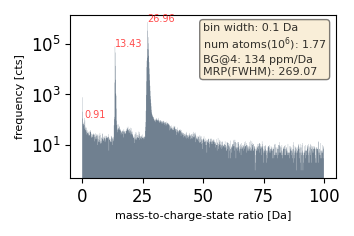

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 269.0684413132576
Peaks  0 is at location and height: (0.91, 116.00) peak window sides (half-maximum) are: (0.81, 1.01)
Peaks  1 is at location and height: (13.43, 77544.00) peak window sides (half-maximum) are: (13.33, 13.53)
Peaks  2 is at location and height: (26.96, 714887.00) peak window sides (half-maximum) are: (26.86, 26.96)


In [29]:
percent_mrp = 50
# background = {'calculation': True, 'plot_no_back': True, 'plot': False, 'mode': 'fabc', 'patch': False, 'lam': 1e4, 'num_std': 5.0}
background={'calculation': False}
peak_p, peaks_y_p, peak_widths_p = tools.hist_plot(mc_p_1[mc_p_1 < 100], 0.1, prominence=40, distance=20, text_loc='right', percent=percent_mrp, plot=True, fig_name='mc2_p_1'+figname, background=background)
index_max_ini = np.argmax(peaks_y_p)
mrp = (peak_p[index_max_ini] / (peak_widths_p[index_max_ini][2] - peak_widths_p[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peak_p)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peak_p[i], peaks_y_p[i]), 'peak window sides (half-maximum) are: ({:.2f}, {:.2f})'.format(peak_widths_p[i][1], peak_widths_p[i][2]))

In [30]:
data_c = data.copy(deep = True)
data_c['t_c (ns)'] = variables.dld_t_calib
data_c['mc_c (Da)'] = mc_p_1

In [34]:
# Remove negative mc
threshold = 0
mc_t = data_c['mc_c (Da)'].to_numpy()
mc_t_mask = (mc_t <= threshold)
print('The number of ions with negative mc are:', len(mc_t_mask[mc_t_mask==True]))
data_c.drop(np.where(mc_t_mask)[0], inplace=True)
data_c.reset_index(inplace=True, drop=True)

The number of ions with negative mc are: 755


In [35]:
data_c

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp,t_c (ns)
0,0.0,0.0,0.0,27.139704,26.784518,5260.239258,5260.239258,52493.0,631.738386,0.0,-0.257878,-2.301796,0,1,606.433107
1,0.0,0.0,0.0,27.009601,27.010308,5260.239258,5260.239258,52549.0,630.305064,0.0,1.187510,1.509061,56,1,605.131316
2,0.0,0.0,0.0,26.941824,26.866870,5260.239258,5260.239258,53132.0,621.499392,0.0,0.741796,-0.038204,583,1,604.451915
3,0.0,0.0,0.0,26.898614,26.774577,5260.239258,5260.239258,53523.0,620.751870,0.0,0.563510,-0.576245,391,1,604.018326
4,0.0,0.0,0.0,26.966205,26.613477,5260.239258,5260.239258,53592.0,628.789446,0.0,-0.012735,-2.209469,69,1,604.696414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775962,0.0,0.0,0.0,27.127101,27.017762,5703.551758,5703.551758,4605.0,611.767890,0.0,2.069388,1.149306,196,1,606.307143
1775963,0.0,0.0,0.0,26.978958,27.234073,5703.551758,5703.551758,4668.0,625.607334,0.0,0.767265,3.212327,63,1,604.824252
1775964,0.0,0.0,0.0,27.584848,27.757134,5703.551758,5703.551758,6574.0,607.214178,0.0,-0.089143,0.468000,1906,1,610.863794
1775965,0.0,0.0,0.0,27.027022,27.444189,5703.551758,5703.551758,6834.0,620.477550,0.0,-0.312000,2.731592,260,1,605.305811


The peak index for MRP calculation is: 2


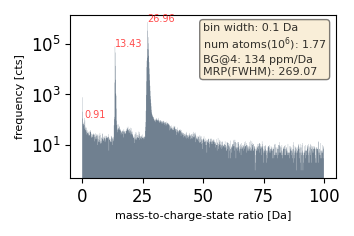

The peak index for MRP calculation is: 2


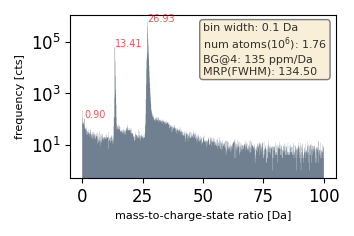

In [36]:
cc = data_c['mc_c (Da)'].to_numpy()
# cc[cc <= 0] = 0
peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(mc_p_1[mc_p_1 < 100], 0.1, distance=10, percent=50, prominence=50, selector='peak', plot=True, label='mc')
peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(cc[cc < 100], 0.1, distance=10, percent=50, prominence=50, selector='peak', plot=True, label='mc')

In [37]:
# save the new data
name_save_file = variables.result_path + '//' + dataset_name + '.h5'
data_tools.store_df_to_hdf(name_save_file, data_c, 'df')

In [ ]:
# save data as epos file
epos = ccapt_tools.ccapt_to_epos(data_c, path=variables.result_path, name=dataset_name + '.epos')
pos = ccapt_tools.ccapt_to_pos(data_c, path=variables.result_path, name=dataset_name + '.POS')

In [ ]:
# save data in csv format
data_tools.store_df_to_csv(data_c, variables.result_path + dataset_name + '.csv')